**M-07 Pengembang Machine Learning dan Front-End**

Hanif Al Irsyad

Universitas Amikom Yogyakarta

Sleman,Yogyakarta

In [126]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM, Bidirectional, Dropout
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
df = pd.read_csv('/content/coffee.csv', encoding= 'unicode_escape')
df.head()

,Date,Open,High,Low,Close,Volume,Currency
0,2000-01-03,122.25,124.00,116.10,116.50,6640,USD
1,2000-01-04,116.25,120.50,115.75,116.25,5492,USD
2,2000-01-05,115.00,121.00,115.00,118.60,6165,USD
3,2000-01-06,119.00,121.40,116.50,116.85,5094,USD
4,2000-01-07,117.25,117.75,113.80,114.15,6855,USD


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5741 entries, 0 to 5740
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      5741 non-null   object 
 1   Open      5741 non-null   float64
 2   High      5741 non-null   float64
 3   Low       5741 non-null   float64
 4   Close     5741 non-null   float64
 5   Volume    5741 non-null   int64  
 6   Currency  5741 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 314.1+ KB


In [ ]:
df['Date']=pd.to_datetime(df['Date'])
df['Date'].head()
df['Open'].fillna(df['Open'].mean(), inplace=True) 
df = df[['Date','Open' ]]
df.head(10)

,Date,Open
0,2000-01-03,122.25
1,2000-01-04,116.25
2,2000-01-05,115.00
3,2000-01-06,119.00
4,2000-01-07,117.25
5,2000-01-10,123.50
6,2000-01-11,115.50
7,2000-01-12,117.80
8,2000-01-13,119.25
9,2000-01-14,117.75


In [ ]:
coffee=df[['Date','Open']].copy()
coffee['Time'] = coffee['Date'].dt.date
df_new=coffee.drop('Date',axis=1)
df_new.set_index('Time', inplace= True)
df_new.head(10)

,Open
Time,
2000-01-03,122.25
2000-01-04,116.25
2000-01-05,115.00
2000-01-06,119.00
2000-01-07,117.25
2000-01-10,123.50
2000-01-11,115.50
2000-01-12,117.80
2000-01-13,119.25


In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5741 entries, 2000-01-03 to 2022-08-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5741 non-null   float64
dtypes: float64(1)
memory usage: 89.7+ KB


In [ ]:
df_new.dropna()

,Open
Time,
2000-01-03,122.25
2000-01-04,116.25
2000-01-05,115.00
2000-01-06,119.00
2000-01-07,117.25
...,...
2022-08-22,215.00
2022-08-23,224.55
2022-08-24,234.35


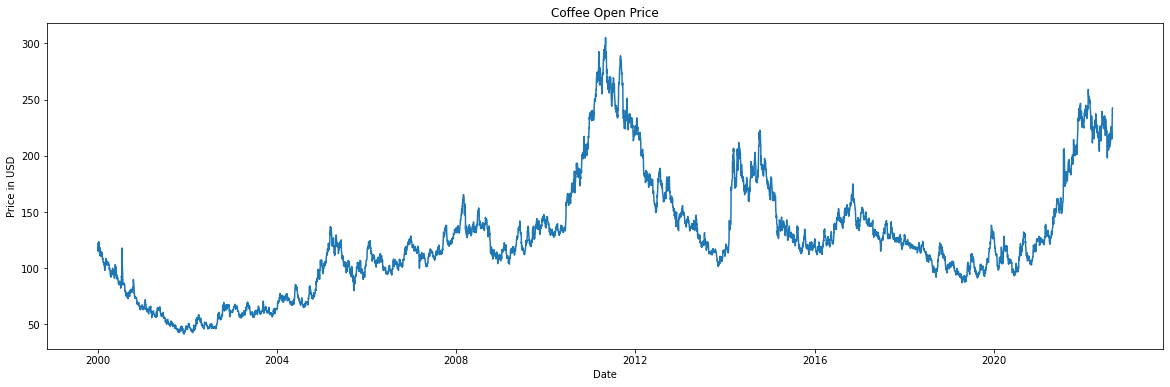

In [ ]:
x = df['Date'].values
y = df['Open'].values

plt.figure(figsize=(20,6))
plt.plot(df_new)
plt.title('Coffee Open Price')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

data = df['Open'].values
data_new = data.reshape(-1,1)
scaler = MinMaxScaler()
data_scaler = scaler.fit_transform(data_new)
data_scaler = data_scaler.reshape(1,-1)
data_scaler = np.hstack(data_scaler)
data_scaler


array([0.30610311, 0.28335861, 0.27862017, ..., 0.73104625, 0.76250948,
       0.76231994])

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, data_scaler, test_size=0.2, random_state=0, shuffle=False)
print(len(X_train), len(X_test))

4592 1149


In [131]:
set_latih = windowed_dataset(y_train, 
                             window_size=64, 
                             batch_size=200, 
                             shuffle_buffer=1000,
                             )

val_test = windowed_dataset(y_test, 
                            window_size=64, 
                            batch_size=200, 
                            shuffle_buffer=1000)

In [132]:
model = tf.keras.models.Sequential([
    Bidirectional(LSTM(60, return_sequences=True)),
    Bidirectional(LSTM(60)),
    Dense(30, activation="relu"),
    Dense(10, activation="relu"),
    Dense(1),
])

In [133]:
data_mae = (np.max(data_scaler) - np.min(data_scaler)) * 0.1
print(data_mae)

0.1


In [134]:
class Callbackdts(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< data_mae) and (logs.get('val_mae') < data_mae):
      self.model.stop_training = True
      print('\nFor Epoch', epoch, ' training has been stopped.''\n Because MAE of the model has reach < 10% of data scale')
callbacks = Callbackdts()

In [135]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(set_latih,
                    epochs=100,
                    validation_data=val_test, 
                    callbacks=[callbacks])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


23/23 [==============================] - 16s 390ms/step - loss: 0.0490 - mae: 0.2648 - val_loss: 0.0570 - val_mae: 0.2948
Epoch 2/100
23/23 [==============================] - 7s 311ms/step - loss: 0.0392 - mae: 0.2294 - val_loss: 0.0459 - val_mae: 0.2575
Epoch 3/100
23/23 [==============================] - 7s 311ms/step - loss: 0.0316 - mae: 0.1996 - val_loss: 0.0380 - val_mae: 0.2259
Epoch 4/100
23/23 [==============================] - 7s 312ms/step - loss: 0.0261 - mae: 0.1779 - val_loss: 0.0321 - val_mae: 0.1992
Epoch 5/100
23/23 [==============================] - 8s 317ms/step - loss: 0.0222 - mae: 0.1620 - val_loss: 0.0276 - val_mae: 0.1765
Epoch 6/100
23/23 [==============================] - 7s 309ms/step - loss: 0.0192 - mae: 0.1496 - val_loss: 0.0241 - val_mae: 0.1571
Epoch 7/100
23/23 [==============================] - 7s 313ms/step - loss: 0.0170 - mae: 0.1394 - val_loss: 0.0214 - val_mae: 0.1412
Epoch 8/100
23/23 [==============================] - 7s 312ms/step - loss: 0.015

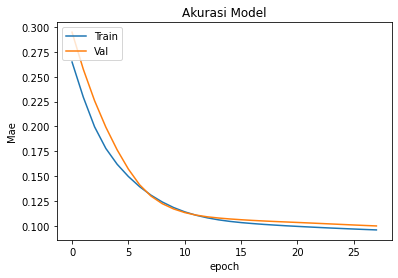

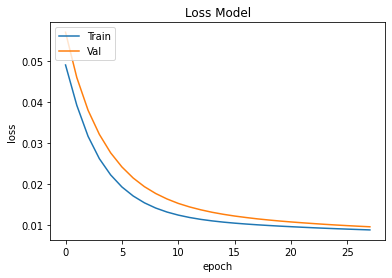

In [137]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Akurasi Model')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()